In [1]:
# Подключение библиотек ## Загрузить при запуске предобученной сети
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
from PIL import Image 
import torch 
from torch import nn, optim 
import torchvision.transforms as transforms 
from typing import Type, Union 
from IPython.display import clear_output, display 
from ipywidgets import Output 
from tqdm.auto import trange 
from numpy.random import randint 
import os 
import zipfile 
from torch.utils.data import Dataset 
from torchvision import datasets 

%matplotlib inline

In [2]:
# Инициализация значений генератора случайных чисел 
np.random.seed(13) 
torch.manual_seed(13) 
 
# device = "cuda" if torch.cuda.is_available() else "cpu" ## Загрузить при запуске предобученной сети для теста Attack
device = "cpu"
print('device = ', device)

device =  cpu


In [3]:
# Класс преобразования контейнера ## Загрузить при запуске предобученной сети
class PreprocessImage: 
    # Получение информации о границах изображения 
    def edge_information(self, image): 
        img_np = np.array(image*255).transpose(1, 2, 0).astype(np.uint8) 
        canny = cv.Canny(img_np,100,200) 
        tau = 2 
        edge = (canny + 1) / tau 
        edge = np.exp(edge * (-1)) 
        return torch.from_numpy(edge) 

    # Получение информации о цветности изображения 
    def chrominance_information(self, image): 
        new_img = image #* 255 
        y = 0.299 * new_img[0] + 0.587 * new_img[1] + 0.114 * new_img[2] 
        cb = 0.564*(new_img[2] - y)  
        cr = 0.713*(new_img[0] - y) 
        teta = 0.25 
        cb_norm = torch.square(cb) 
        cr_norm = torch.square(cr) 
        chrominance = (cb_norm + cr_norm) / (teta ** 2) * (-1) 
        chrominance = torch.exp(chrominance) * (-1) + 1 
        return chrominance
    
    # Преобразование изображения 
    def preprocess_cover(self, image): 
        img_norm = torch.zeros(image.size()) 
        chrominance = self.chrominance_information(image) 
        edge = self.edge_information(image) 
        know = (chrominance + edge) / 2 
        img_norm[0] = image[0] + know - 1 
        img_norm[1] = image[1] + know - 1 
        img_norm[2] = image[2] + know - 1 
        return img_norm 

In [4]:
# Класс датасета 
class ImageDataset(Dataset): 
    # Инициализация переменных 
    def __init__(self, path): 
        self.path = path 
        self.cover_files = os.listdir(f'{self.path}/cover') 
        self.logo_files = os.listdir(f'{self.path}/wm')  
        self.transform =  transforms.Compose([transforms.ToTensor()]) 
        self.preprocess = PreprocessImage() 
 
    # Длина датасета 
    def __len__(self): 
        return len(self.cover_files) 
 
    # Получение элемента датасета 
    def __getitem__(self, idx): 
        cover_path = self.cover_files[idx] 
        logo_path = self.logo_files[idx] 
        cover = Image.open(f'{self.path}/cover/{cover_path}').convert('RGB') #(f'{self.path}/covers/{cover_path}').convert('RGB') 
        logo = Image.open(f'{self.path}/wm/{logo_path}') #(f'{self.path}/logo/{logo_path}') 
        cover = self.transform(cover) 
        logo = self.transform(logo) 
        cover_norm = self.preprocess.preprocess_cover(cover) 
        return cover, logo, cover_norm 

In [5]:
# формирование данных в нужном формате

import random
from shutil import copyfile

def split_data(main_dir, training_dir, validation_dir, test_dir):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string): path to be used for testing
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.8 * len(shuffled_files)) #the training split casted into int for numeric rounding
    test_split = int(0.9 * len(shuffled_files))#the test split
    
    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:test_split] # validation split
    test = shuffled_files[test_split:]
    
    for element in train:
            copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    for element in test:
        copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))

In [23]:
split_data('DATASETs/cover', 'DATASETs/dataset/train/cover', 'DATASETs/dataset/validation/cover', 'DATASETs/dataset/test/cover')
split_data('DATASETs/wm', 'DATASETs/dataset/train/wm', 'DATASETs/dataset/validation/wm', 'DATASETs/dataset/test/wm')

In [5]:
#  перечисляю длины каталогов
DATASET = 'dataset-catsdogs'
print(len(os.listdir(f'{DATASET}/train/cover')))
print(len(os.listdir(f'{DATASET}/train/wm')))

print(len(os.listdir(f'{DATASET}/validation/cover')))
print(len(os.listdir(f'{DATASET}/validation/wm')))

# print(len(os.listdir(f'{DATASET}/test/cover')))
# print(len(os.listdir(f'{DATASET}/test/wm')))

9999
9999
2500
2500


In [6]:
# Инициализация тестовой и обучающей выборки 
train_dataset = ImageDataset(f'{DATASET}/train') 
# test_dataset = ImageDataset(f'{DATASET}/test')
validation_dataset = ImageDataset(f'{DATASET}/validation')

batch_size = 64

train_dataloader = torch.utils.data.DataLoader( 
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0 
)
validation_dataloader = torch.utils.data.DataLoader( 
    validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0 
) 
# test_dataloader = torch.utils.data.DataLoader( 
#     test_dataset, batch_size=batch_size, shuffle=False, num_workers=0 
# ) 

In [7]:
# Класс кодировщика ## Загрузить при запуске предобученной сети
class Encoder(nn.Module): 
    # Инициализация слоев нейросети 
    def __init__(self): 
        super(Encoder, self).__init__() 
         
        self.conv1_watermark = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.conv2_watermark = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv3_watermark = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv4_watermark = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1) 
        self.conv5_watermark = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

        self.conv5_1_watermark = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # antiBotteleneck
        self.conv5_2_watermark = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv5_3_watermark = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5_4_watermark = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv5_5_watermark = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv5_6_watermark = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.conv6_watermark = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1) 
        self.conv7_watermark = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1) 
        self.conv1_cover = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) 
        self.conv2_cover = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1) 
        self.conv3_cover = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv4_cover = nn.Conv2d(in_channels=96, out_channels=16, kernel_size=3, padding=1) 
        self.conv5_cover = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv6_cover = nn.Conv2d(in_channels=48, out_channels=16, kernel_size=3, padding=1) 
        self.conv7_cover = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        
        self.conv8_cover = nn.Conv2d(in_channels=51, out_channels=64, kernel_size=3, padding=1) 
        
        self.conv9_cover = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        self.conv9_1_cover = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) 

        self.conv9_2_cover = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9_3_cover = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        
        self.conv9_4_cover = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        
        self.conv10_cover = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1) 
        self.conv11_cover = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1) 
        self.conv12_cover = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1) 
        self.conv13_cover = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1) 
 
        self.activator = nn.ReLU() 

# Структура нейросети 
    def forward(self, input): 
        (cover, watermark, cover_orig) = input
 
        watermark = self.conv1_watermark(watermark) 
        cover = self.conv1_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv2_watermark(watermark) 
        watermark = self.conv3_watermark(watermark) 
        cover = self.conv2_cover(cover) 
        cover = self.conv3_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv4_watermark(watermark) 
        watermark = self.conv5_watermark(watermark)
        
        watermark = self.conv5_1_watermark(watermark) # antiBotteleneck
        watermark = self.conv5_2_watermark(watermark)
        watermark = self.conv5_3_watermark(watermark)
        watermark = self.conv5_4_watermark(watermark)
        watermark = self.conv5_5_watermark(watermark)
        watermark = self.conv5_6_watermark(watermark)
        
        cover = self.conv4_cover(cover)
        cover = self.conv5_cover(cover) 
 
        cover = torch.cat([cover, watermark], 1) 
 
        watermark = self.conv6_watermark(watermark) 
        watermark = self.conv7_watermark(watermark) 
        cover = self.conv6_cover(cover) 
        cover = self.conv7_cover(cover) 
 
        cover = torch.cat([cover, watermark, cover_orig], 1)
         
        cover = self.conv8_cover(cover) 
        cover = self.activator(self.conv9_cover(cover)) 
        cover = self.activator(self.conv9_1_cover(cover))

        # drop = torch.nn.Dropout(.06) # 6% весовых коэффициентов обнулится
        # cover = drop(cover)
        
        cover = self.activator(self.conv9_2_cover(cover))
        
        cover = self.activator(self.conv9_3_cover(cover))
        cover = self.activator(self.conv9_4_cover(cover))
        
        cover = self.activator(self.conv10_cover(cover)) 
        cover = self.activator(self.conv11_cover(cover)) 
        cover = self.activator(self.conv12_cover(cover)) 
        cover = self.conv13_cover(cover) 
 
        return cover 

In [8]:
# Класс декодера ## Загрузить при запуске предобученной сети
class Decoder(nn.Module): 
    # Инициализация слоев нейросети 
    def __init__(self): 
        super(Decoder, self).__init__() 
         
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # antiBotteleneck
        self.conv2_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv2_4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.conv2_6 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.conv2_7 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1)
        self.conv2_8 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv2_9 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1) 
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1) 
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1) 
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1) 
         
        self.bn1 = nn.BatchNorm2d(16) 
        self.bn2 = nn.BatchNorm2d(32)
        
        self.bn2_1 = nn.BatchNorm2d(64)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.bn2_3 = nn.BatchNorm2d(256)
        self.bn2_4 = nn.BatchNorm2d(512)
        self.bn2_5 = nn.BatchNorm2d(1024)
        self.bn2_6 = nn.BatchNorm2d(512)
        self.bn2_7 = nn.BatchNorm2d(128)
        self.bn2_8 = nn.BatchNorm2d(64)
        self.bn2_9 = nn.BatchNorm2d(32)
        
        self.bn3 = nn.BatchNorm2d(64) 
        self.bn4 = nn.BatchNorm2d(128) 
        self.bn5 = nn.BatchNorm2d(64) 
        self.bn6 = nn.BatchNorm2d(32) 
        self.bn7 = nn.BatchNorm2d(16) 
 
        self.activator = nn.ReLU() 
 
    # Структура нейросети 
    def forward(self, input): 
        output = self.activator(self.bn1(self.conv1(input)))       
        output = self.activator(self.bn2(self.conv2(output)))

        output = self.activator(self.bn2_1(self.conv2_1(output))) # antiBotteleneck
        output = self.activator(self.bn2_2(self.conv2_2(output)))
        output = self.activator(self.bn2_3(self.conv2_3(output)))
        output = self.activator(self.bn2_4(self.conv2_4(output)))
        output = self.activator(self.bn2_5(self.conv2_5(output)))
        output = self.activator(self.bn2_6(self.conv2_6(output)))
        output = self.activator(self.bn2_7(self.conv2_7(output)))
        output = self.activator(self.bn2_8(self.conv2_8(output)))
        output = self.activator(self.bn2_9(self.conv2_9(output)))
        
        output = self.activator(self.bn3(self.conv3(output)))                           
        output = self.activator(self.bn4(self.conv4(output)))

        # drop = torch.nn.Dropout(.02) # 2% весовых коэффициентов обнулится
        # output = drop(output)
        
        output = self.activator(self.bn5(self.conv5(output)))        
        output = self.activator(self.bn6(self.conv6(output))) 
        output = self.activator(self.bn7(self.conv7(output))) 
        output = self.conv8(output)
        return output 

In [9]:
# Класс симулятора атаки ## Загрузить при запуске предобученной сети
class Attack: 

    def luma_jpg(self, image, p=0): #  индивидуальный уровень качества яркости, 0–100, по умолчанию 0 - не используется.
        img_np = np.asarray(image.cpu().detach()*255).transpose(1,2,0) 
        encode_param = [int(cv.IMWRITE_JPEG_LUMA_QUALITY), p] 
        result, encimg = cv.imencode('.jpg', img_np, encode_param) 
        decimg = cv.imdecode(encimg, 1) 
        return transforms.ToTensor()(decimg)

    def chroma_jpg(self, image, p=0): # независимый уровень качества цветности, 0–100, по умолчанию 0 - не используется.
        img_np = np.asarray(image.cpu().detach()*255).transpose(1,2,0) 
        encode_param = [int(cv.IMWRITE_JPEG_CHROMA_QUALITY), p] 
        result, encimg = cv.imencode('.jpg', img_np, encode_param) 
        decimg = cv.imdecode(encimg, 1) 
        return transforms.ToTensor()(decimg)
     
    def jpg(self, image, p=90): #  качество от 0 до 100 (чем выше, тем лучше). Значение по умолчанию 95.
        img_np = np.asarray(image.cpu().detach()*255).transpose(1,2,0) 
        encode_param = [int(cv.IMWRITE_JPEG_QUALITY), p] 
        result, encimg = cv.imencode('.jpg', img_np, encode_param) 
        decimg = cv.imdecode(encimg, 1) 
        return transforms.ToTensor()(decimg)

    def Filter2D(self, image): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0)
        sharp_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Sharpening kernel
        sharpen_img = cv.filter2D(img_np, ddepth=-1, kernel=sharp_filter) 
        return transforms.ToTensor()(sharpen_img) 

    def iDentity(self, image): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0)
        sharp_filter = np.array([[0, 0, 0], [0, 2, 0], [0, 0, 0]])
        sharpen_img = cv.filter2D(img_np, ddepth=-1, kernel=sharp_filter) 
        return transforms.ToTensor()(sharpen_img)

    def BoxBlur(self, image): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0)
        sharp_filter = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]) *1/12 # Box blurring kernel
        sharpen_img = cv.filter2D(img_np, ddepth=-1, kernel=sharp_filter) 
        return transforms.ToTensor()(sharpen_img)

    def erosion(self, image): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0)
        kernel = np.ones((5,5), np.uint8)
        sharpen_img = cv.erode(img_np, kernel) # расширить изображения
        return transforms.ToTensor()(sharpen_img)

    def BilateralFilter(self, image): 
        img_np = np.asarray(image.cpu().detach()).transpose(1,2,0) # Двусторонний фильтр может очень хорошо уменьшить  
        sharpen_img = cv.bilateralFilter(img_np, 11, 75,75) # нежелательный шум,
        return transforms.ToTensor()(sharpen_img) # сохраняя при этом четкие края

    # Кадрирование 
    def cropping(self, image): 
        crop = torch.ones(image.size()).to(device) 
        a = randint(0,crop.shape[1]) 
        c = randint(0,crop.shape[2]) 
        crop[:,a:int(a*1.5),c:int(c*1.5)] = 0 
        return image * crop 
 
    # Выбивание пикселей 
    def dropout(self, image, p=0.01): 
        mask = np.random.choice([0,1],image.size()[1:],True,[p,1-p]) 
        mask = torch.from_numpy(mask).to(device) 
        return image[:] * mask 

  
    # Случайная атака 
    def random_attack(self, image): 
        attack = randint(6,10) # random integers from low (inclusive) to high (exclusive)
        p = randint(0,100)
        
        #print(f'p = {p}, attack = {attack}')
        with open("attack.txt", "a+") as attackfile:
            attackfile.write(f'attack = {attack}\n')
            
        if attack == 0: 
            return self.luma_jpg(image, p) 
        elif attack == 1: 
            return self.chroma_jpg(image, p) 
        elif attack == 2:  
            return self.BoxBlur(image) 
        elif attack == 3:
            return self.Filter2D(image)
        elif attack == 4:
            return self.iDentity(image)
        elif attack == 5:
            return self.jpg(image, p)
        elif attack == 6:
            return self.erosion(self.jpg(image, p))
        elif attack == 7:
            return self.BilateralFilter(self.jpg(image, p))
        elif attack == 8:
            return self.cropping(self.jpg(image, p))
        elif attack == 9:
            return self.dropout(self.jpg(image, p))
        return image

In [10]:
# Класс автокодировщика ## Загрузить при запуске предобученной сети
class AutoEncoder(nn.Module): 
    # Инициализация переменных 
    def __init__(self) -> None: 
        super().__init__() 
 
        self.encoder = Encoder() 
        self.decoder = Decoder() 
         
        self.attack_class = Attack() 
        self.alfa = 0.5 
        self.beta = 0.5 
         
        self.criterion = nn.MSELoss() 
 
    # Кодирование 
    def encode(self, x, y, z): 
        return self.encoder((x,y,z))
 
    # Декодирование 
    def decode(self, x): 
        return self.decoder(x) 
 
    
    # Проведение атаки на изображения 
    def attack(self, batch): 
        noise_batch = torch.ones(batch.size()).to(device) 
        for i in range(batch.size()[0]): 
            noise_batch[i] = self.attack_class.random_attack(batch[i]) 
        return noise_batch 
 
    # Вычисление ошибки модели 
    def compute_loss( 
        self,  
        cover: torch.Tensor,  
        watermark: torch.Tensor,  
        cover_norm: torch.Tensor  
    ) -> torch.Tensor: 
 
        encode_image = self.encode(cover_norm, watermark, cover)
        
        encode_loss = self.criterion(cover,encode_image) 
         
 
        # noise_image = self.attack(encode_image) 
        # decode_image = self.decode(noise_image)#(encode_image) 

        decode_image = self.decode(encode_image)
         
 
        decode_loss = self.criterion(watermark,decode_image) 
         
        loss = self.alfa * encode_loss + self.beta * decode_loss
 
        return loss 

In [11]:
# Обучение одной эпохи 
def train_epoch( 
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    number, 
    verbose_num_iters: int = 32, 
    device: torch.device = "cuda", 
) -> list[float]: 
    model.to(device) 
    model.train() 
    epoch_loss_trace = [] 
 
    display() 
    out = Output() 
    display(out) 
 
    for i, batch in enumerate(train_dataloader): 
        cover, logo, cover_norm = batch 
        cover = cover.to(device) 
        logo = logo.to(device) 
        cover_norm = cover_norm.to(device) 
        loss = model.compute_loss(cover, logo, cover_norm)
        loss.backward() 
        optimizer.step() # update model
        optimizer.zero_grad() 
        epoch_loss_trace.append(loss.item()) 
 
        if (i + 1) % verbose_num_iters == 0: 
            with out: 
                clear_output(wait=True) 
 
                plt.figure(figsize=(10, 5)) 
                plt.subplot(1, 2, 1) 
                plt.title(f"Current epoch loss: {number} = {epoch_loss_trace[-1]}", fontsize=17)
                plt.xlabel("Iteration", fontsize=16) 
                plt.ylabel("Reconstruction trainloss", fontsize=16) 
                plt.grid() 
                plt.plot(epoch_loss_trace) 
                plt.show() 
 
    out.clear_output()
    
    return epoch_loss_trace

In [12]:
# Обучение одной эпохи 
def validation_epoch( 
    model: nn.Module, 
    validation_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    number, 
    verbose_num_iters: int = 32, 
    device: torch.device = "cuda", 
) -> list[float]: 
    model.to(device) 
    model.eval() #.train() 
    epoch_loss_trace = [] 
 
    display() 
    out = Output() 
    display(out)

    with torch.no_grad():
        for i, batch in enumerate(validation_dataloader): 
            cover, logo, cover_norm = batch 
            cover = cover.to(device) 
            logo = logo.to(device) 
            cover_norm = cover_norm.to(device) 
            loss = model.compute_loss(cover, logo, cover_norm)
            # loss.backward() 
            # optimizer.step() 
            #optimizer.zero_grad() 
            epoch_loss_trace.append(loss.item()) 
     
            if (i + 1) % verbose_num_iters == 0: 
                with out: 
                    clear_output(wait=True) 
     
                    plt.figure(figsize=(10, 5)) 
                    plt.subplot(1, 2, 1) 
                    plt.title(f"Current epoch loss: {number} = {epoch_loss_trace[-1]}", fontsize=17)
                    plt.xlabel("Iteration", fontsize=16) 
                    plt.ylabel("Reconstruction validloss", fontsize=16) 
                    plt.grid() 
                    plt.plot(epoch_loss_trace) 
                    plt.show() 
     
        out.clear_output()
    
    return epoch_loss_trace

In [13]:
# Обучение модели 
def train_model( 
    model: nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int = 5, 
    verbose_num_iters: int = 32, 
    device: torch.device = "cpu" 
) -> None: 
    loss_trace = [] 
    valloss_trace = []
    epoch_number = 1 
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True): 
        epoch_loss_trace = train_epoch( 
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            number = epoch_number, 
            verbose_num_iters=verbose_num_iters, 
            device=device, 
        )

        epoch_valloss_trace = validation_epoch( 
            model=model, 
            validation_dataloader=validation_dataloader, 
            optimizer=optimizer, 
            number = epoch_number, 
            verbose_num_iters=verbose_num_iters, 
            device=device, 
        )

        PATH = f'savedmodel/mycatsanddogs/model-{epoch}epochs.pth'
        torch.save(model.state_dict(), PATH)
        
        loss_trace += epoch_loss_trace
        valloss_trace += epoch_valloss_trace
        epoch_number += 1 
 
    plt.figure(figsize=(10, 5)) 
    # plt.title(f"Total trainingloss = {loss_trace[-1]:.2f}, validationloss = {valloss_trace[-1]:.2f}", fontsize=13) 
    plt.title(f"Total trainingloss = {loss_trace[-1]:.2f}", fontsize=13)
    plt.xlabel("Iteration", fontsize=16) 
    plt.ylabel("Reconstruction loss", fontsize=16) 
    plt.grid() 
    plt.plot(loss_trace, label='train', color='k')
    # plt.plot(valloss_trace, label='validation', color='r')
    plt.legend()
    plt.show() 

    plt.figure(figsize=(10, 5)) 
    plt.title(f"Total validationloss = {valloss_trace[-1]:.2f}", fontsize=13) 
    plt.xlabel("Iteration", fontsize=16) 
    plt.ylabel("Reconstruction loss", fontsize=16) 
    plt.grid() 
    # plt.plot(loss_trace, label='train', color='k')
    plt.plot(valloss_trace, label='validation', color='r')
    plt.legend()
    plt.show() 
 
    model.train() #.eval()

In [ ]:
model = AutoEncoder() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_model(model, train_dataloader, optimizer, 10, device=device) 
# Save:
PATH = 'savedmodel/mycatsanddogs/model.pth'
torch.save(model.state_dict(), PATH)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

In [15]:
# Print model's state_dict
with open('Model_state_dict.txt', 'w') as f:
    print("Model's state_dict:\n", file=f)    
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size(), file=f)

# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# Print optimizer's state_dict
with open('Optimizer_state_dict.txt', 'w') as f:
    print("Optimizer's state_dict:\n", file=f)
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name], file=f)

# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [67]:
#!pip install netron
import netron
netron.start('savedmodel/model-step0.pth', 8081)

Stopping http://localhost:8081
Serving 'savedmodel/model-step0.pth' at http://localhost:8081


('localhost', 8081)

> *Создайте свою модель с набором данных 64 × 64, отладьте ее как обычно, 
а затем обучите точно такую же модель с набором данных 128 × 128. Не 
с нуля, а используя параметры, которые уже были обучены. Как только 
вы получите максимум из набора данных 128 × 128, перейдите к целевым 
данным 256 × 256. Скорее всего, вы найдете процентную точку или два 
улучшения в точности. *

> *Хотя мы не знаем точно, почему это работает, гипотеза заключается в том, 
что, обучаясь при более низких разрешениях, модель узнает об общей 
структуре изображения и может обработать эти знания по мере увеличения изображений.*

> *Эта концепция «начинай с меньшего и получи больше» также применима к архитектуре.*

### Пойнтер	Ян "Программируем с PyTorch: Создание приложений глубокого обучения". — СПб.: Питер, 2020. (стр. 97)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

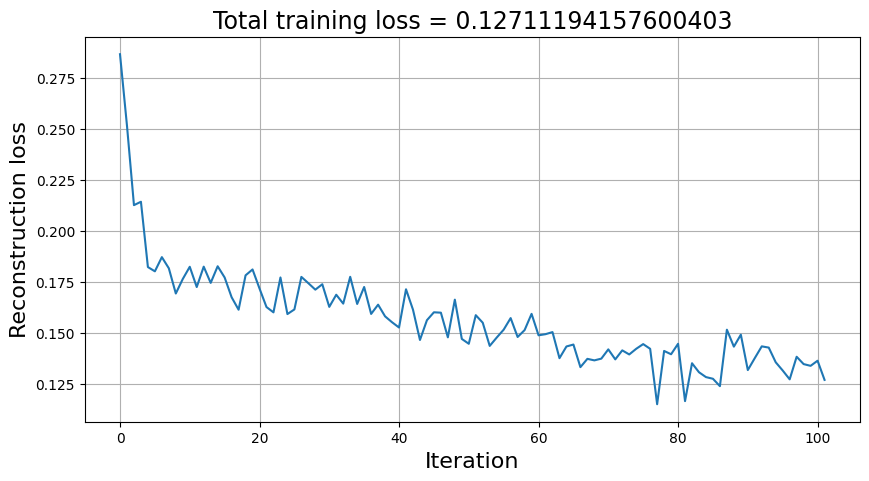

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

i = 1, lr = 0.0002, batch_size = 32


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

i = 2, lr = 0.0004, batch_size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

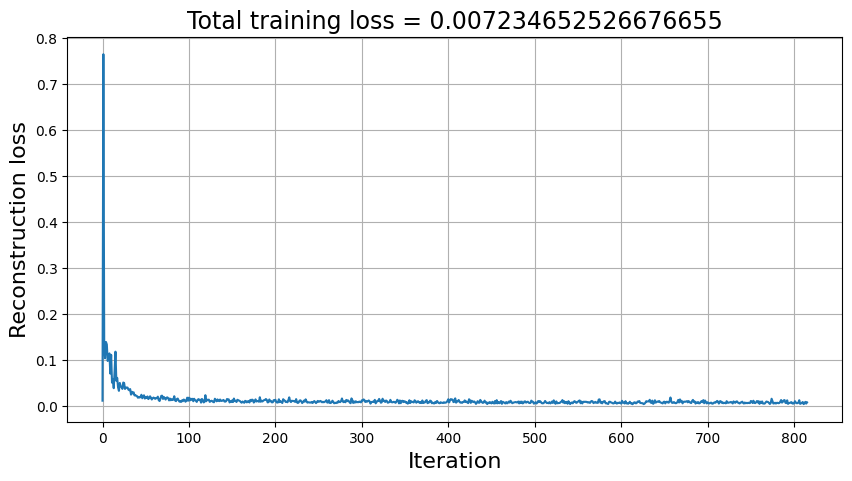

i = 3, lr = 0.0008, batch_size = 8


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

Output()

Output()

i = 4, lr = 0.0016, batch_size = 4


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

i = 5, lr = 0.002, batch_size = 2


In [14]:
# Каскадное обучение (единый запуск)

lr = 1e-4
quantity_epochs = 3

model = AutoEncoder() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
train_model(model, train_dataloader, optimizer, quantity_epochs, device=device) 
# Save:
PATH = 'savedmodel/model-step0.pth'
torch.save(model.state_dict(), PATH)


batch_size = 64

net = AutoEncoder()
net.load_state_dict(torch.load(PATH))

for i in range(1,6):
    if i == 5:
        quantity_epochs = 6
        lr = 1e-3
    
    lr=lr*2
    
    optimizer = optim.Adam(net.parameters(), lr=lr)

    batch_size = batch_size // 2
    
    # split_data(f'DATASETs/cover{i}', f'DATASETs/dataset{i}/train/cover', f'DATASETs/dataset{i}/validation/cover', f'DATASETs/dataset{i}/test/cover')
    # split_data(f'DATASETs/wm{i}', f'DATASETs/dataset{i}/train/wm', f'DATASETs/dataset{i}/validation/wm', f'DATASETs/dataset{i}/test/wm')

    train_dataset = ImageDataset(f'DATASETs/dataset{i}/train') 
    test_dataset = ImageDataset(f'DATASETs/dataset{i}/test') 
 
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    train_model(net, train_dataloader, optimizer, quantity_epochs, device=device)
    
    print(f"i = {i}, lr = {lr}, batch_size = {batch_size}")

    PATH = f'savedmodel/model-step{i}.pth'
    torch.save(net.state_dict(), PATH)

    net.load_state_dict(torch.load(PATH))

In [45]:
# Load: ## Загрузить при запуске предобученной сети
PATH = 'savedmodel/mycatsanddogs/model-3epochs.pth'
net = AutoEncoder()
net.load_state_dict(torch.load(PATH))
net.eval() 
# ".eval() is a kind of switch for some specific layers/parts of the model
# that behave differently during training and inference (evaluating) time.
# For example, Dropouts Layers, BatchNorm Layers etc. You need to turn them
#     off during model evaluation, and .eval() will do it for you."

AutoEncoder(
  (encoder): Encoder(
    (conv1_watermark): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_1_watermark): Conv2d(16, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_2_watermark): Conv2d(13, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7_watermark): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_cover): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_cover): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=

In [25]:
numel_list = [p.numel() for p in net.parameters()]
sum(numel_list)#, numel_list # -- кол-во параметров сети 

1032213

In [26]:
def imgshow(img):
    npimg = np.array(img)
    plt.imshow(npimg)
    plt.show()

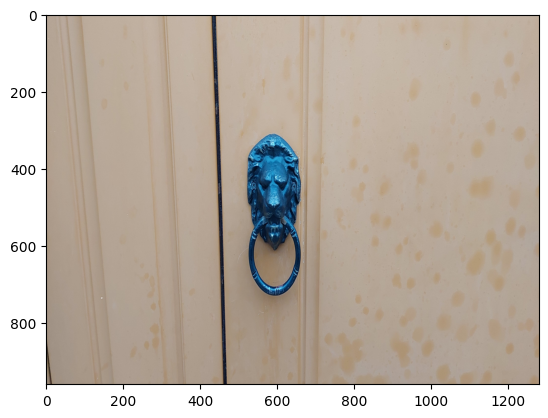

In [46]:
cover_test = Image.open('img/d.jpg').convert('RGB')
cover_width, cover_height = cover_test.size
cover_test = cover_test.resize((1280,960)) # .resize((256,128))
imgshow(cover_test)
# print(type(cover_test))

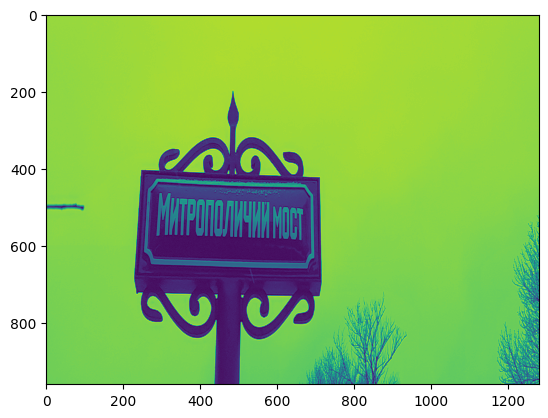

In [47]:
# logo_test = Image.open('PetImages/Dog/21.jpg').convert('L').resize((128,128))
logo_test = Image.open('img/m.jpg').convert('L')
logo_width, logo_height = logo_test.size
logo_test = logo_test.resize((1280,960))
imgshow(logo_test)

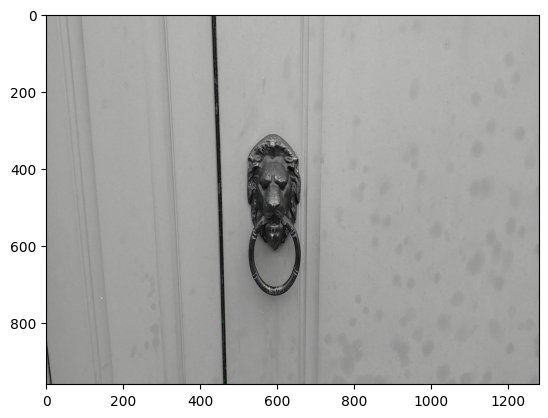

In [48]:
trans = transforms.Compose([transforms.ToTensor()]) 
cover_test = trans(cover_test)

logo_test = trans(logo_test)
test2 = net.encode(cover_test.unsqueeze(0), logo_test.unsqueeze(0), cover_test.unsqueeze(0))

imgtest2 = test2[0]
img = transforms.ToPILImage()(imgtest2)
imgshow(img)
img.save("img/cover-with-wm.jpg")

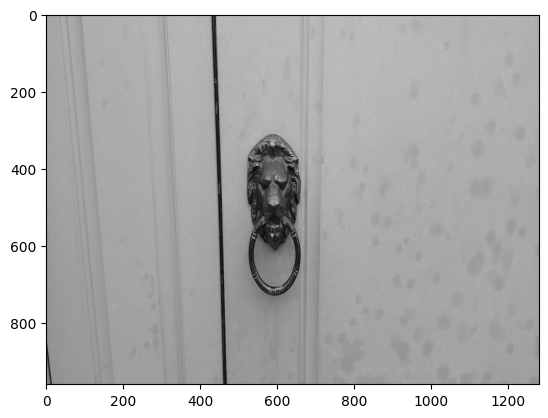

In [43]:
# Extract

img = Image.open('img/cover-with-wm.jpg').convert("RGB")

imgshow(img)

In [ ]:
img = trans(img)
test3 = net.decode(img.unsqueeze(0))

imgtest3 = test3[0]

img3 = transforms.ToPILImage()(imgtest3)
imgshow(img3)

img3.save("img/extract-wm-resize.jpg")

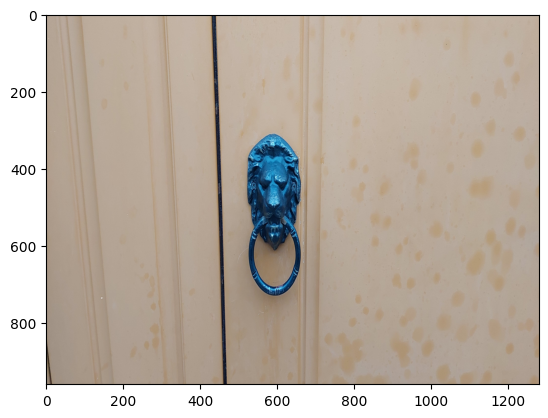

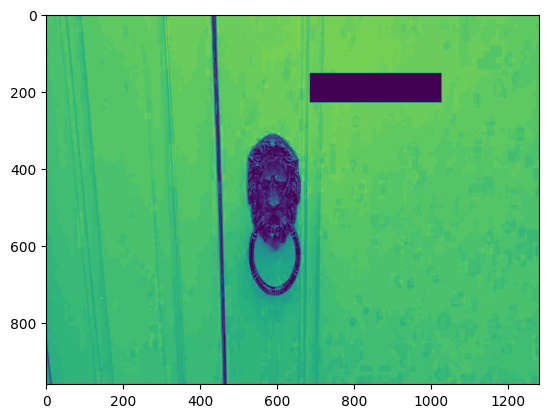

In [33]:
testattack = Attack()
cover_test = Image.open('img/d.jpg').convert('RGB').resize((1280,960))
imgshow(cover_test)

trans = transforms.Compose([transforms.ToTensor()]) 
cover_test = trans(cover_test)
test2attack = testattack.random_attack(cover_test) 

img4 = test2attack[0]
img4 = transforms.ToPILImage()(img4)
imgshow(img4)

In [34]:
img4.save("img/d_random_attack.jpg")